In [1]:
import os
import datetime
import pandas as pd

from astropy.io import ascii

def getMkdir(dirPath: str) -> str:
	if not os.path.exists(dirPath):
		os.mkdir(dirPath)
	return dirPath

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-254-1",
	3: "TYC 3620-332-1"
}

OBSV_DATE = datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d")
BASE_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/"
# BASE_DATA_DIR = "/run/media/ramon/USBD/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(BASE_DATA_DIR, d) for d in os.listdir(BASE_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(BASE_DATA_DIR, d))][0]

assert os.path.exists(DATE_DATA_DIR)
DATE_DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06'

In [30]:
# TODO: turn observed times to UTC; currently in local time only

import numpy as np
from scipy import stats

PHOTOMETRIC_BASE_KEYS = ["SUM", "AREA", "FLUX", "MAG", "MERR"]
OBSV_KEY = "OTIME"
EPOCH_OBSV_KEY = "E_OTIME"

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "qphot_results")
data = ascii.read(os.path.join(qphotResultsDir, "phot"))
pandasData = data.to_pandas()
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
pandasData[EPOCH_OBSV_KEY] = (pandasData[OBSV_KEY] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1s")
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()
	starResultsDir = getMkdir(os.path.join(qphotResultsDir, starName))
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		apertureDir = getMkdir(os.path.join(starResultsDir, f"{rapert} - {apertureRadius}"))
		for basePhotKey in PHOTOMETRIC_BASE_KEYS:
			photKey = f"{basePhotKey}{apertureId}"
			photDf = starData[[EPOCH_OBSV_KEY, photKey]].copy()
			photDf = photDf[~(np.isnan(photDf[photKey]))]
			# photDf['z_score'] = np.abs(stats.zscore(photDf[photKey]))
			photDf = photDf[(np.abs(stats.zscore(photDf[photKey])) < 3)]
			photDf.to_csv(os.path.join(apertureDir, f"{basePhotKey}.dat"), index=False, sep=' ')

data

IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,XERR,YERR,CIER,CERROR,MSKY,STDEV,SSKEW,NSKY,NSREJ,SIER,SERROR,ITIME,XAIRMASS,IFILTER,OTIME,RAPERT1,SUM1,AREA1,FLUX1,MAG1,MERR1,PIER1,PERROR1,RAPERT2,SUM2,AREA2,FLUX2,MAG2,MERR2,PIER2,PERROR2,RAPERT3,SUM3,AREA3,FLUX3,MAG3,MERR3,PIER3,PERROR3
imagename,pixels,pixels,,filename,,pixels,pixels,pixels,pixels,pixels,pixels,,cerrors,counts,counts,counts,npix,npix,,serrors,timeunit,number,name,timeunit,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors
str23,float64,float64,int64,str6,int64,float64,float64,float64,float64,float64,float64,int64,str8,float64,float64,float64,int64,int64,int64,str7,float64,float64,str9,str23,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7
s_bdf_2022-12-06_19-13-,964.000,601.000,1,coords,1,964.641,601.835,0.641,0.835,0.039,0.041,0,NoError,968.9499,51.48885,-1.393325,1238,10,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,24.00,1790039,1809.714,36516.89,18.039,0.102,0,NoError,25.00,1939004,1963.986,36000.36,18.055,0.111,0,NoError,26.00,2094303,2123.723,36521.58,18.039,0.116,0,NoError
s_bdf_2022-12-06_19-13-,654.000,1072.000,2,coords,2,658.142,1073.789,4.142,1.789,0.004,0.004,107,BigShift,969.8943,51.2674,-14.83585,1240,3,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,24.00,4775580,1809.865,3020202,13.245,0.001,0,NoError,25.00,4928199,1963.693,3023624,13.244,0.001,0,NoError,26.00,5086046,2124.155,3025840,13.243,0.002,0,NoError
s_bdf_2022-12-06_19-13-,1413.000,755.000,3,coords,3,1414.832,756.824,1.832,1.824,0.003,0.003,107,BigShift,982.3401,51.91189,22.12392,1230,3,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,24.00,6895413,1809.909,5117467,12.673,0.001,0,NoError,25.00,7050228,1963.56,5121344,12.672,0.001,0,NoError,26.00,7210615,2124.243,5123885,12.671,0.001,0,NoError
s_bdf_2022-12-06_19-14-,964.000,601.000,4,coords,1,964.903,601.554,0.903,0.554,0.021,0.016,0,NoError,970.3138,30.9295,10.38494,1242,13,0,NoError,60,1.091365,Luminance,2022-12-06T19:14:30.021,24.00,1794223,1809.154,38776.5,17.974,0.058,0,NoError,25.00,1944076,1964.318,38070.88,17.994,0.063,0,NoError,26.00,2098481,2123.446,38071.59,17.994,0.067,0,NoError
s_bdf_2022-12-06_19-14-,654.000,1072.000,5,coords,2,658.219,1073.777,4.219,1.777,0.003,0.003,107,BigShift,971.6819,38.52644,9.44703,1241,4,0,NoError,60,1.091365,Luminance,2022-12-06T19:14:30.021,24.00,4771308,1809.675,3012880,13.248,0.001,0,NoError,25.00,4923714,1963.771,3015553,13.247,0.001,0,NoError,26.00,5081445,2124.069,3017526,13.246,0.001,0,NoError
s_bdf_2022-12-06_19-14-,1413.000,755.000,6,coords,3,1414.138,757.015,1.138,2.015,0.003,0.003,107,BigShift,985.6694,35.44371,-13.74429,1239,4,0,NoError,60,1.091365,Luminance,2022-12-06T19:14:30.021,24.00,6873527,1810.293,5089177,12.679,0.001,0,NoError,25.00,7028458,1963.233,5093360,12.678,0.001,0,NoError,26.00,7190734,2124.277,5096899,12.677,0.001,0,NoError
s_bdf_2022-12-06_19-15-,964.000,601.000,7,coords,1,965.946,601.094,1.946,0.094,0.040,0.029,107,BigShift,982.1954,35.35438,14.46632,1220,20,0,NoError,60,1.092225,Luminance,2022-12-06T19:15:30.170,24.00,1814225,1810.375,36082.83,18.052,0.072,0,NoError,25.00,1963459,1962.968,35441.34,18.072,0.078,0,NoError,26.00,2120857,2124.46,34222.26,18.110,0.086,0,NoError
s_bdf_2022-12-06_19-15-,654.000,1072.000,8,coords,2,658.330,1073.969,4.330,1.969,0.003,0.004,107,BigShift,982.4161,36.08882,12.89783,1238,2,0,NoError,60,1.092225,Luminance,2022-12-06T19:15:30.170,24.00,4790879,1809.502,3013195,13.248,0.001,0,NoError,25.00,4945351,1964.377,3015515,13.247,0.001,0,NoError,26.00,5103899,2123.634,3017606,13.246,0.001,0,NoError


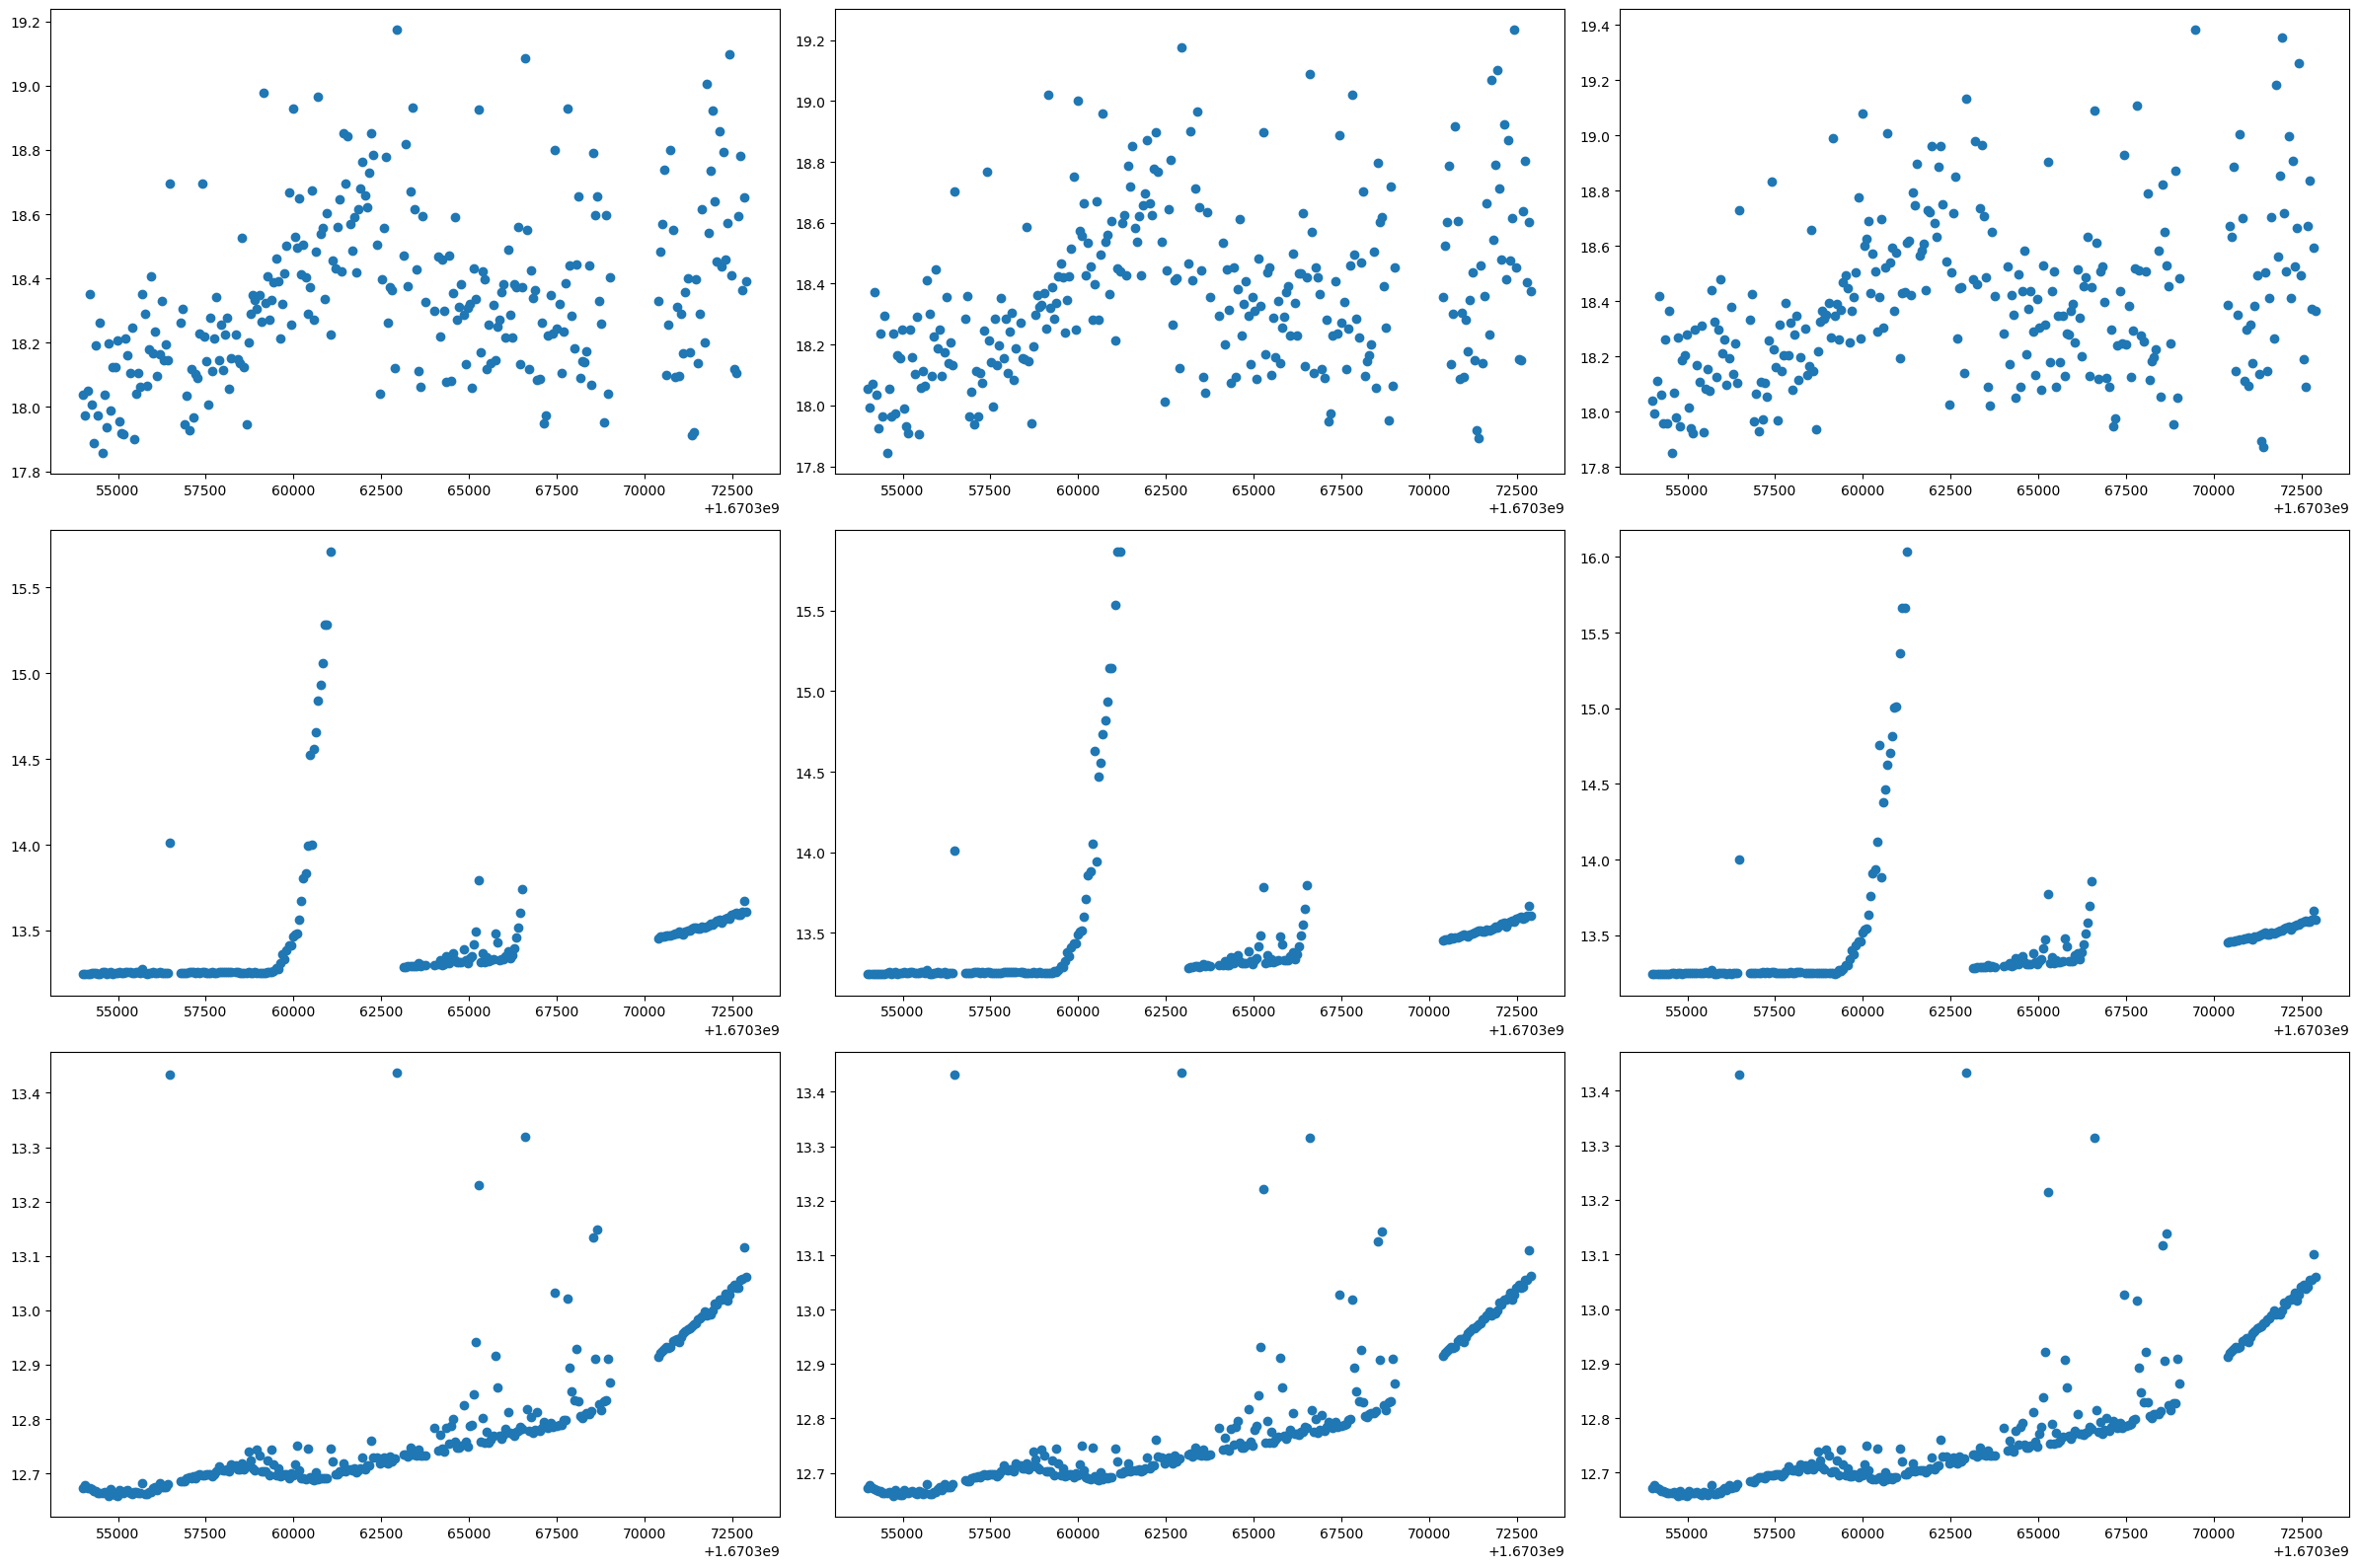

In [31]:
import matplotlib.pyplot as plt

FILE = "MAG.dat"
COL =  "MAG"
OBJ_NAMES = ["ATO J339.9469+45.1464", "TYC 3620-254-1","TYC 3620-332-1"]
figure, axes = plt.subplots(nrows=3, ncols=len(OBJ_NAMES), figsize=(24, 16))

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "qphot_results")

def plotApertureMags(subplots, objName: str):
	objDir = os.path.join(qphotResultsDir, objName)
	apertureDirs = os.listdir(objDir)
	for i in range(len(subplots)):
		curApertureDir = os.path.join(objDir, apertureDirs[i])
		objData = pd.read_csv(os.path.join(curApertureDir, FILE), sep=' ')
		subplots[i].scatter(objData['E_OTIME'], objData[f'{COL}{i + 1}'])

for i in range(len(OBJ_NAMES)):
	subplots = axes[i]
	plotApertureMags(subplots, OBJ_NAMES[i])

# OBJ_NAME = "TYC 3620-254-1"

# figure, axes = plt.subplots(nrows=3, ncols=1, figsize=(24, 16))
# r1plot, r2plot, r3plot = axes
# magFile = f"/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/qphot_results/{OBJ_NAME}/RAPERT1 - 24.0/{FILE}"
# mags17 = pd.read_csv(magFile)
# r1plot.scatter(mags17['OTIME'], mags17[f'{COL}1'])

# magFile = f"/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/qphot_results/{OBJ_NAME}/RAPERT2 - 25.0/{FILE}"
# mags18 = pd.read_csv(magFile)
# r2plot.scatter(mags18['OTIME'], mags18[F'{COL}2'], color='red')

# magFile = f"/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06/corrected/qphot_results/{OBJ_NAME}/RAPERT3 - 26.0/{FILE}"
# mags = pd.read_csv(magFile)
# r3plot.scatter(mags['OTIME'], mags[F'{COL}3'], color='green')

figure.tight_layout()
plt.show()